### **Mytransformers的结构**

In [1]:
import torch.nn as nn 
import numpy as np 
import torch

import torch.nn.functional as F 
import math, copy , time 
from torch.autograd import Variable
import matplotlib.pyplot as plt 

#### **Encoder** 部分

##### step 1: Embedding

In [2]:
from MyTransformers import Embeddings

In [3]:
import torch
vocab_size = 4
d_model = 4
words_vec = torch.tensor([[1,2,3]])
embed = Embeddings(vocab_size=vocab_size,
                   d_model = d_model)

In [6]:
embed_words_vec = embed(words_vec)
embed_words_vec,embed_words_vec.shape

(tensor([[[ 1.2454,  1.2795,  1.9745,  0.4878],
          [ 0.2344,  2.9271,  1.5410, -0.7455],
          [ 0.4110,  1.2128,  1.3450, -3.1742]]], grad_fn=<MulBackward0>),
 torch.Size([1, 3, 4]))

`Embeddings`类中会初始化一个权重矩阵:

$ W_{embed}: R^{vocab} \to R^{dmodel} $

将每一个`word_vec`中的向量映射到维度为`d_model`的空间中.同时，具有以下优点：

- 稠密向量比 one-hot 向量更节省空间
- 向量中包含了单词的语义信息，相似的单词在向量空间中距离更近
- 可以被神经网络直接处理，便于训练和优化

查看权重矩阵 $W_{embed}$

In [8]:
embed.embedding_table.weight ,embed.embedding_table.weight.shape

(Parameter containing:
 tensor([[-0.0376, -0.0901, -0.5672, -0.1897],
         [ 0.6227,  0.6398,  0.9872,  0.2439],
         [ 0.1172,  1.4635,  0.7705, -0.3727],
         [ 0.2055,  0.6064,  0.6725, -1.5871]], requires_grad=True),
 torch.Size([4, 4]))

##### step 2: PositionEncodding

In [12]:
from MyTransformers import PositionalEncoding
pos_enc = PositionalEncoding(d_model=d_model,
                             dropout=0.1
                             )

In [14]:
pos_embed_words_vec = pos_enc(embed_words_vec)
pos_embed_words_vec,pos_embed_words_vec.shape

(tensor([[[ 1.3838,  2.5328,  2.1939,  1.6532],
          [ 0.0000,  3.8527,  0.0000,  0.2827],
          [ 1.4670,  0.8851,  1.5166, -2.4160]]], grad_fn=<MulBackward0>),
 torch.Size([1, 3, 4]))

`PositionalEncoding` 的函数公式：

$posenc(x) = x + PE(x.size(1))$

其中,PE函数只是和x的第1维(vec_len)有关,与x本身无关.

$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

$$
PE(pos, 2i + 1) = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

##### step 3: Encoder Layer的第一层:注意力函数与残差链接函数的复合

In [15]:
from MyTransformers import LayerNorm, MultiHeadedAttention,attention

In [16]:
norm = LayerNorm(features=d_model)
norm_x = norm(pos_embed_words_vec)
norm_x

tensor([[[-1.0738,  1.1409,  0.4876, -0.5546],
         [-0.5488,  1.4962, -0.5488, -0.3987],
         [ 0.5888,  0.2784,  0.6152, -1.4824]]], grad_fn=<AddBackward0>)

进行归一化，一方面防止梯度爆炸和稳定反向传播，另一方面在注意力机制核心公式的前提是x要尽可能满足$~N(0,1)$

归一化公式:

$$
\mathbf{y} = [y_1, y_2, \dots, y_d] = \gamma \odot \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$

-  $\gamma $ 和  $\beta$  是可学习的参数，形状与  $\mathbf{x}$ 相同
   
  

In [20]:
from MyTransformers import clones
h = 2
d_k = d_model // h
nbatches = norm_x.size(0)
linears = clones(nn.Linear(d_model,d_model),4)
query,key,value = [l(x).view(nbatches,-1,h,d_k).transpose(1,2) for l,x in zip(linears,(norm_x,norm_x,norm_x))]
print(f'query:',query,'\n',query.shape)
print(f'key:',query,'\n',query.shape)
print(f'value:',query,'\n',query.shape)

query: tensor([[[[-0.5284,  0.0963],
          [-0.2927, -0.2988],
          [ 0.2366, -0.0240]],

         [[ 0.4215, -0.9681],
          [ 0.6588, -0.3928],
          [-0.5448, -0.2104]]]], grad_fn=<TransposeBackward0>) 
 torch.Size([1, 2, 3, 2])
key: tensor([[[[-0.5284,  0.0963],
          [-0.2927, -0.2988],
          [ 0.2366, -0.0240]],

         [[ 0.4215, -0.9681],
          [ 0.6588, -0.3928],
          [-0.5448, -0.2104]]]], grad_fn=<TransposeBackward0>) 
 torch.Size([1, 2, 3, 2])
value: tensor([[[[-0.5284,  0.0963],
          [-0.2927, -0.2988],
          [ 0.2366, -0.0240]],

         [[ 0.4215, -0.9681],
          [ 0.6588, -0.3928],
          [-0.5448, -0.2104]]]], grad_fn=<TransposeBackward0>) 
 torch.Size([1, 2, 3, 2])


这里将原来的d_model维向量分割成了d_k维向量，其中前三个Linear层的权重矩阵可以看成每个由d_model到d_k的线性映射矩阵横向结合.同时输出的Q,K,V也是对应每个d_k向量的横向结合.这里为了带入到attention函数中计算,把seq_len与h的交换位置,不会影响张量对应的向量.

In [22]:
x,attn = attention(query,key,value)
print(x,'\n',x.shape)
print(f'{attn}','\n',attn.shape)

tensor([[[[-0.2325, -0.0713],
          [-0.2144, -0.0804],
          [-0.1775, -0.0765]],

         [[ 0.3019, -0.6203],
          [ 0.3108, -0.5877],
          [ 0.0853, -0.5009]]]], grad_fn=<UnsafeViewBackward0>) 
 torch.Size([1, 2, 3, 2])
tensor([[[[0.3793, 0.3381, 0.2827],
          [0.3435, 0.3557, 0.3008],
          [0.3139, 0.3287, 0.3575]],

         [[0.4608, 0.3336, 0.2057],
          [0.4051, 0.3856, 0.2093],
          [0.3191, 0.2673, 0.4136]]]], grad_fn=<SoftmaxBackward0>) 
 torch.Size([1, 2, 3, 3])


注意力公式：
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^\top}{\sqrt{d_k}}\right) V \in \mathbb{R}^{n \times d_v}
$$

在多头注意力中，$Q,K,V$分别为其中一个head的，总的$Q$为$Q = [Q_1,Q_2,...,Q_h]$,同理$K,V,Attention$

In [24]:
x = x.transpose(1,2).contiguous().view(nbatches,-1,h*d_k)   # 还原为之前的形状
x = linears[-1](x)
x

tensor([[[ 0.1737, -0.3867, -0.3769,  0.2483],
         [ 0.1715, -0.5241, -0.6846,  0.0751],
         [ 0.4038, -0.3603, -0.4194,  0.6586]]], grad_fn=<ViewBackward0>)

设置一个$R^{dmodel} \to R^{dmodel}$的权重矩阵来保证每一个head得到较好结合

残差连接

In [26]:
x = pos_embed_words_vec + x
x

tensor([[[ 2.9412,  4.6789,  4.0109,  3.5546],
         [ 0.1715,  7.1812, -0.6846,  0.6406],
         [ 3.3378,  1.4099,  2.6139, -4.1735]]], grad_fn=<AddBackward0>)

##### step 4:Encoder Layer的第二层: FF 与 残差连接的复合

In [27]:
norm_x = norm(x)

In [29]:
d_ff = 128
w_1 = nn.Linear(d_model,d_ff)
w_2 = nn.Linear(d_ff,d_model)
ff_x = w_2(F.relu(w_1(norm_x)))
ff_x,ff_x.shape

(tensor([[[-0.1656,  0.2626,  0.1866, -0.0804],
          [ 0.0073,  0.3206,  0.4330,  0.0232],
          [ 0.2733, -0.0471, -0.2253, -0.0685]]], grad_fn=<ViewBackward0>),
 torch.Size([1, 3, 4]))

给定输入  $ x \in \mathbb{R}^{d_{\text{model}}} $（单个位置的向量），FFN的计算步骤为：

 **第一层线性变换 + ReLU激活 + 第二层线性变换**

 **整体公式（合并表示）**：
$$\text{FFN}(x) = \text{ReLU}(xW_1 + b_1) W_2 + b_2$$

 **关键特性**：
1. **逐位置独立计算**：FFN对序列中的每个位置 \( x_i \) 独立应用相同的变换，不跨位置共享信息。
2. **扩展-收缩结构**：隐藏层维度$  d_f $ 通常大于输入维度 再投影回原维度。


In [30]:
x = x + ff_x

##### step 5:层归一化

In [31]:
norm_x = norm(x)
norm_x,norm_x.shape

(tensor([[[-1.1494,  1.1737,  0.3757, -0.4001],
          [-0.5024,  1.4922, -0.6196, -0.3703],
          [ 0.8154,  0.1678,  0.4633, -1.4465]]], grad_fn=<AddBackward0>),
 torch.Size([1, 3, 4]))

如果还有下一层layer，则将x之间当作下一层的输入，否则经过归一化后输出,encode部分结束

In [2]:
from MyTransformers import subsequent_mask
mask = subsequent_mask(5)
mask

tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])

In [4]:
import torch
scores = torch.ones(5,5)
scores

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [6]:
scores = scores.masked_fill(mask == 0, -1e9)
scores

tensor([[[ 1.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00, -1.0000e+09, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00, -1.0000e+09],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00]]])

#### **掩码部分**

这里假设两个序列：

 序列1: 无pad `[<s>, A, B, C, </s>]` → `[1,2,3,4,7]`
 
 序列2: 有pad `[<s>, D, E, </s>, pad]` → `[1,5,6,7,0]`

In [6]:
trg = torch.tensor([
    [1, 2, 3, 4, 7],    # 序列1 (无pad)
    [1, 5, 6, 7, 0]  # 序列2 (有pad)
])
src = torch.tensor([[1,2,3,4,7]])

In [7]:
from MyTransformers import Batch
batch = Batch(src=src, trg=trg, pad=0)


##### src 部分

In [8]:
batch.src

tensor([[1, 2, 3, 4, 7]])

In [10]:
batch.src_mask,batch.src_mask.shape

(tensor([[[True, True, True, True, True]]]), torch.Size([1, 1, 5]))

##### trg 部分

In [12]:
batch.trg,trg

(tensor([[1, 2, 3, 4],
         [1, 5, 6, 7]]),
 tensor([[1, 2, 3, 4, 7],
         [1, 5, 6, 7, 0]]))

In [13]:
batch.trg_y

tensor([[7],
        [0]])

只处理pad的掩码

In [14]:
base_mask = (batch.trg != 0).unsqueeze(-2)
base_mask

tensor([[[True, True, True, True]],

        [[True, True, True, True]]])

In [17]:
base_mask.shape

torch.Size([2, 1, 4])

只处理注意力掩码(即只能看到前面位置的下三角矩阵)

In [18]:
from MyTransformers import subsequent_mask
attn_mask = Variable(subsequent_mask(batch.trg.size(-1)).type_as(base_mask.data))

In [19]:
attn_mask,attn_mask.shape

(tensor([[[ True, False, False, False],
          [ True,  True, False, False],
          [ True,  True,  True, False],
          [ True,  True,  True,  True]]]),
 torch.Size([1, 4, 4]))

两者掩码结合

In [20]:
tgt_mask = base_mask & attn_mask
tgt_mask,tgt_mask.shape

(tensor([[[ True, False, False, False],
          [ True,  True, False, False],
          [ True,  True,  True, False],
          [ True,  True,  True,  True]],
 
         [[ True, False, False, False],
          [ True,  True, False, False],
          [ True,  True,  True, False],
          [ True,  True,  True,  True]]]),
 torch.Size([2, 4, 4]))

计算让解码器生成的掩码部分有效数量(除去pad)

In [21]:
(batch.trg_y != 0)

tensor([[ True],
        [False]])

In [22]:
print((batch.trg_y != 0).data.sum())
batch.ntokens

tensor(1)


tensor(1)

#### **优化器部分**

In [2]:
from MyTransformers import make_model
vocab_size = 8
model = make_model(vocab_size,vocab_size)

##### model_size = vocab_size

In [3]:
model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forword): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-5): 6 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_

In [4]:
model.src_embed

Sequential(
  (0): Embeddings(
    (embedding_table): Embedding(512, 8)
  )
  (1): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [5]:
model.src_embed[0].d_model

8

##### model.parameters() 便利所有的参数

In [6]:
for param in model.parameters():
    print(f"Parameter shape: {param.shape}")
    print(f"Parameter data (first values): {param.data[:2]}")
    print("-" * 30)

Parameter shape: torch.Size([512, 512])
Parameter data (first values): tensor([[-0.0323, -0.0191,  0.0284,  ...,  0.0005,  0.0428, -0.0199],
        [ 0.0198, -0.0027,  0.0255,  ..., -0.0131, -0.0264,  0.0236]])
------------------------------
Parameter shape: torch.Size([512])
Parameter data (first values): tensor([0.0055, 0.0420])
------------------------------
Parameter shape: torch.Size([2048, 512])
Parameter data (first values): tensor([[ 0.0023, -0.0157, -0.0304,  ..., -0.0373, -0.0108,  0.0046],
        [ 0.0091,  0.0363,  0.0052,  ...,  0.0056,  0.0356, -0.0305]])
------------------------------
Parameter shape: torch.Size([2048])
Parameter data (first values): tensor([-5.5496e-05, -1.1207e-02])
------------------------------
Parameter shape: torch.Size([512, 2048])
Parameter data (first values): tensor([[ 0.0108,  0.0107, -0.0054,  ..., -0.0204,  0.0092,  0.0061],
        [ 0.0086,  0.0147,  0.0045,  ..., -0.0019,  0.0050,  0.0053]])
------------------------------
Parameter shap

Text(0, 0.5, 'rate')

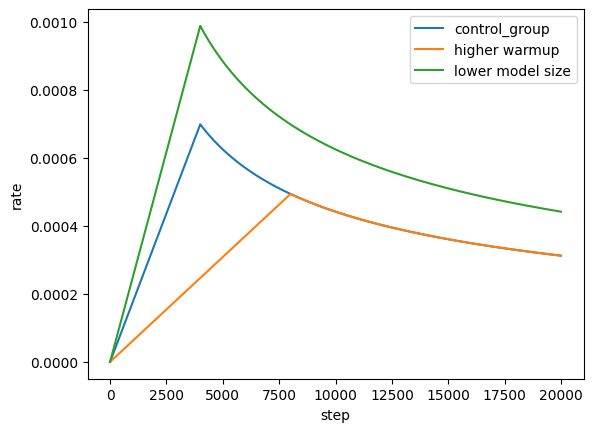

In [9]:
from MyTransformers import NoamOpt
opts = [NoamOpt(model_size=512,factor=1,warmup=4000,optimizer=None),
        NoamOpt(model_size=512,factor=1,warmup=8000,optimizer=None),
        NoamOpt(model_size=256,factor=1,warmup=4000,optimizer=None)]
plt.plot(np.arange(1,20000),[[opt.rate(i) for opt in opts] for i in range(1,20000)])
plt.legend(['control_group','higher warmup','lower model size'])
plt.xlabel('step')
plt.ylabel('rate')

从图中分析，模型参数越低，rate能到达的峰值越高.warmup越高，模型需要更久的时间到达峰值且峰值较低。

##### smooth 处理

标签平滑是一种正则化技术，用于解决分类任务中过度自信（over-confidence）问题。传统方法使用 one-hot 编码（正确类概率=1，其他类=0），这会导致模型过度拟合训练数据。标签平滑通过以下方式改进：

正确类分配概率：1 - smoothing

其他类均匀分配剩余概率：smoothing / (vocab_size - 2)

In [11]:
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])

In [12]:
x = Variable(predict.log())
target = Variable(torch.LongTensor([2, 1, 0]))

In [13]:
smoothing = 0.4
size = 5
pad_index = 0
true_dist = x.data.clone()
true_dist.fill_(smoothing / (size - 2))

tensor([[0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        [0.1333, 0.1333, 0.1333, 0.1333, 0.1333],
        [0.1333, 0.1333, 0.1333, 0.1333, 0.1333]])

In [16]:
target.data.unsqueeze(1)

tensor([[2],
        [1],
        [0]])

In [15]:
true_dist.scatter_(1, target.data.unsqueeze(1), 1.0-smoothing)

tensor([[0.1333, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.1333, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.6000, 0.1333, 0.1333, 0.1333, 0.1333]])

正确值被赋予了confidence值(1.0-smoothing=0.6),其他值被赋予了smoothing/(size-2)值

In [17]:
true_dist[:, pad_index] = 0
true_dist

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.1333, 0.1333, 0.1333, 0.1333]])

将pad的部分正确值赋0

In [19]:
mask = torch.nonzero(target.data == pad_index)
mask.squeeze()

tensor(2)

目标为填充符的样本损失=0

In [20]:
if mask.dim() > 0:
    true_dist.index_fill_(0, mask.squeeze(), 0.0)
true_dist

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

Text(0, 0.5, 'loss(x)')

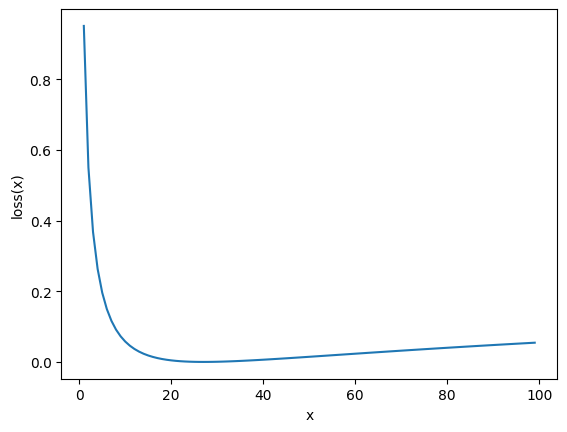

In [9]:
from MyTransformers import LabelSmoothing
crit = LabelSmoothing(size=5,padding_idx=0,smoothing=0.1)
def loss(x):
    d = x + 3.0
    predict = torch.FloatTensor([[1e-9,x/d,1/d,1/d,1/d],]) # 收敛为[0,1,0,0,0]
    return crit(Variable(predict.log()),Variable(torch.LongTensor([1]))).item()
plt.plot(np.arange(1,100),[loss(x) for x in range(1,100)])
plt.xlabel('x')
plt.ylabel('loss(x)')